# IDEAC Vizualisation 

In [2]:
import numpy
from functools import reduce
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import read_csv
from pandas.plotting import scatter_matrix
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import keras
import json
import os
import sklearn
import numpy
from datetime import datetime
from dateutil.parser import parse

Using TensorFlow backend.


## 1. Formatages des fichiers JSON

In [7]:
def concatenate_json_to_df(directory_path, to_output, folder_output):
    list_json = []
    
    for file in os.listdir(directory_path):
        if file.split(".")[-1] == "json":
            
            with open(directory_path+file, 'r') as f:
            
                # If json file is not empty
                if os.stat(directory_path+file).st_size != 0:
                                
                        
                    # For Observation file type
                    if directory_path.split("/")[-2] == "Observations":
                        dictio = json.load(f)
                                            
                        if 'observation' in dictio:
                            observation = dictio["observation"]
                        
                            for entry in observation:
                                entry['date'] =  file.rstrip(".json")
                                entry['station'] = dictio['station']
                                entry['time'] = datetime.utcfromtimestamp(entry['time']).strftime('%d-%m-%Y %H:%M:%S')
                                list_json.append(entry)
                    
                    
                    # For Analyses file type
                    elif directory_path.split("/")[-2] == "Analyses":
                        dictio = json.load(f)
                        if 'source' in dictio and 'temperature' in dictio:
                            source = list(dictio['source'])
                            temperature = list(dictio['temperature'])
                            
                            dictio['date'] = file.rstrip(".json")
                            dictio.pop('source', None)
                            dictio.pop('temperature', None)
                            
                            entry = dict()
                            for i in range(0, len(source)):
                                dictio[source[i]] = temperature[i]
                                list_json.append(dictio)

                                
                    # For Previsions file type
                    elif "Previsions" in directory_path.split("/"):
                        dictio = json.load(f)
                        
                        latit_r = None
                        long_r = None
                        
                        if "longitude_r" in dictio:
                            long_r = dictio['longitude_r']

                        if "latitude_r" in dictio:
                            latit_r = dictio['latitude_r']
                            
                        if 'forecast' in dictio:
                            forecast = dictio['forecast'] 
                            
                            
                            for i in range(0, len(forecast)):
                                dictio = dict()
                                
                                if long_r != None and latit_r != None:
                                    dictio['latitude_r'] = latit_r
                                    dictio['longitude_r'] = long_r
                                
                                if "temperature" in forecast[i]:
                                    dictio["temperature"] = forecast[i]["temperature"]
                                    
                                if "time" in forecast[i]:
                                    dictio["time"] = datetime.utcfromtimestamp(forecast[i]["time"]).strftime('%d-%m-%Y %H:%M:%S')
                                    
                                if "wind" in forecast[i]:
                                    dictio["wind"] = forecast[i]["wind"]
                                
                                if "wind_dir" in forecast[i]:
                                    dictio["wind_dir"] = forecast[i]["wind_dir"]
                                
                                if "humidity" in forecast[i]:
                                    dictio["humidity"] = forecast[i]["humidity"]
                                
                                if "pressure" in forecast[i]:
                                            dictio["pressure"] = forecast[i]["pressure"]
                                        
                                if "cloud_cover" in forecast[i]:
                                            dictio["cloud_cover"] = forecast[i]["cloud_cover"]

    
                                
                                dictio["date"] = file.rstrip(".json")
                                
                                list_json.append(dictio)
                
                
                else:
                    dictio = dict()
                    dictio["date"] = file.rstrip(".json")
                    list_json.append(dictio)
                                    
    df = pd.DataFrame(list_json)
    df.drop_duplicates()
    df.to_csv(folder_output+"/"+to_output.replace("/", "-")+".csv", sep=";", index=False)

Stores the cleaned files to dirname

In [8]:
dirname = "technical_challenge_v9"
if not os.path.exists(dirname):
    os.mkdir(dirname)

In [9]:
#testing the formatting function for one folder
concatenate_json_to_df('technical_challenge/Asport CAPRED/Previsions/Api-Agro/', "Asport CAPRED/Previsions/Api-Agro", dirname)

Cleaning in all folder of path recursively

In [10]:
path = "technical_challenge/"
for directories in os.listdir(path):
       
    for folder in os.listdir(path+directories):
           
        if folder == "Previsions":
            for folder2 in os.listdir(path+directories+"/"+folder):
                
                concatenate_json_to_df(path+directories+"/"+folder+"/"+folder2+"/", directories+"/"+folder+"/"+folder2, dirname)
                print(path+directories+"/"+folder+"/"+folder2)
        else: 
            print(path+directories+"/"+folder)
            concatenate_json_to_df(path+directories+"/"+folder+"/", directories+"/"+folder, dirname)

NotADirectoryError: [Errno 20] Not a directory: 'technical_challenge/.DS_Store'

# 2. Data Vizualisation

### Observations 

In [12]:
asport_v = read_csv('technical_challenge_v9/Asport CAPRED-Observations.csv',sep = ";")
asport_viz = asport_v.drop(['time', 'station', 'precipitation'],axis=1).groupby(['date']).mean()

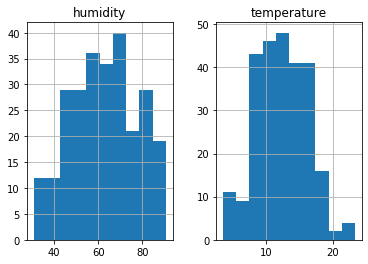

In [13]:
# Distribution with histograms
asport_viz.hist()
plt.show()

In [14]:
# Calculate correlation Coefficient 
corr = asport_viz.corr()
print(corr)

             humidity  temperature
humidity     1.000000    -0.589665
temperature -0.589665     1.000000


### Previsions 

In [15]:
asport_v2 = read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Weatherbit.csv',sep = ";")
asport_viz2 = asport_v2.drop(['latitude_r', 'longitude_r'],axis=1).groupby(['date']).mean()

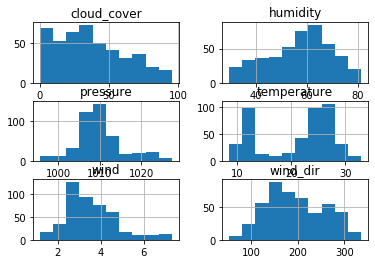

In [16]:
# Distribution with histograms
asport_viz2.hist()
plt.show()

             cloud_cover  humidity  pressure  temperature      wind  wind_dir
cloud_cover     1.000000  0.351727 -0.369140    -0.298016  0.080418  0.114548
humidity        0.351727  1.000000  0.021441    -0.408073 -0.466715 -0.354464
pressure       -0.369140  0.021441  1.000000    -0.292429 -0.110563 -0.204590
temperature    -0.298016 -0.408073 -0.292429     1.000000  0.004114 -0.184253
wind            0.080418 -0.466715 -0.110563     0.004114  1.000000  0.259934
wind_dir        0.114548 -0.354464 -0.204590    -0.184253  0.259934  1.000000


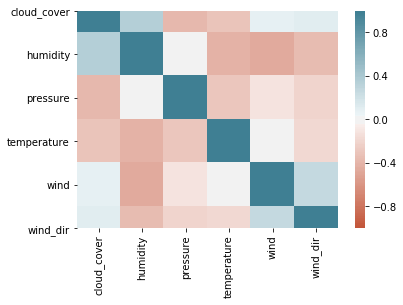

In [17]:
# Calculate correlation Coefficient 
corr = asport_viz2.corr()
print(corr)

# Heat Map - could be useful when we will have more data for precipitation variable
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

# Forecasters Analysis ASPORT

#### Temperature based dataset

In [18]:
asport_obs = pd.read_csv('technical_challenge_v9/Asport CAPRED-Observations.csv',sep = ";")
asport_obs = asport_obs.drop(['date', 'humidity', 'precipitation', 'station'],axis=1).dropna()
asport_obs["time"] = pd.to_datetime(asport_obs['time'], format='%d-%m-%Y %H:%M:%S')
asport_obs.sort_values(by='time')
asport_obs['time'] = asport_obs['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_obs.columns = ['temperature_obs','time']
asport_obs = asport_obs.groupby('time', as_index=False).mean()

asport_prev_apiagro = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Api-Agro.csv',sep = ";")
asport_prev_apiagro = asport_prev_apiagro.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_apiagro["time"] = pd.to_datetime(asport_prev_apiagro['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_apiagro.sort_values(by='time')
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_apiagro.columns = ['temperature_apiagro','time'] 
asport_prev_apiagro = asport_prev_apiagro.groupby('time', as_index=False).mean()

asport_prev_darksky = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Dark Sky.csv',sep = ";")
asport_prev_darksky = asport_prev_darksky.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_darksky["time"] = pd.to_datetime(asport_prev_darksky['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_darksky.sort_values(by='time')
asport_prev_darksky['time'] = asport_prev_darksky['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_darksky.columns = ['temperature_darksky','time'] 
asport_prev_darksky = asport_prev_darksky.groupby('time', as_index=False).mean()

asport_prev_infoclimat = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Infoclimat.csv',sep = ";")
asport_prev_infoclimat = asport_prev_infoclimat.drop(['cloud_cover', 'date', 'humidity', 'pressure', 'wind',
                                                      'wind_dir'],axis=1).dropna()
asport_prev_infoclimat["time"] = pd.to_datetime(asport_prev_infoclimat['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_infoclimat.sort_values(by='time')
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_infoclimat.columns = ['temperature_infoclimat','time'] 
asport_prev_infoclimat = asport_prev_infoclimat.groupby('time', as_index=False).mean()

asport_prev_openweathermap = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-OpenWeatherMap.csv',sep = ";")
asport_prev_openweathermap = asport_prev_openweathermap.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                              'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_openweathermap["time"] = pd.to_datetime(asport_prev_openweathermap['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_openweathermap.sort_values(by='time')
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_openweathermap.columns = ['temperature_openweathermap','time'] 
asport_prev_openweathermap = asport_prev_openweathermap.groupby('time', as_index=False).mean()

asport_prev_meteoconcept = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Meteo Concept.csv',sep = ";")
asport_prev_meteoconcept = asport_prev_meteoconcept.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_meteoconcept["time"] = pd.to_datetime(asport_prev_meteoconcept['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_meteoconcept.sort_values(by='time')
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_meteoconcept.columns = ['temperature_meteoconcept','time'] 
asport_prev_meteoconcept = asport_prev_meteoconcept.groupby('time', as_index=False).mean()

asport_prev_wunderground = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Wunderground.csv',sep = ";")
asport_prev_wunderground = asport_prev_wunderground.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_wunderground["time"] = pd.to_datetime(asport_prev_wunderground['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_wunderground.sort_values(by='time')
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_wunderground.columns = ['temperature_wunderground','time'] 
asport_prev_wunderground = asport_prev_wunderground.groupby('time', as_index=False).mean()

asport_prev_weatherbit = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Weatherbit.csv',sep = ";")
asport_prev_weatherbit = asport_prev_weatherbit.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                      'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_weatherbit["time"] = pd.to_datetime(asport_prev_weatherbit['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_weatherbit.sort_values(by='time')
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_weatherbit.columns = ['temperature_weatherbit','time'] 
asport_prev_weatherbit  = asport_prev_weatherbit.groupby('time', as_index=False).mean()

#### Merge DataFrames in a single file

In [19]:
prevs = pd.merge(asport_obs,asport_prev_apiagro[['time', 'temperature_apiagro']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_darksky[['time', 'temperature_darksky']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_infoclimat[['time', 'temperature_infoclimat']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_meteoconcept[['time', 'temperature_meteoconcept']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_openweathermap[['time', 'temperature_openweathermap']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_wunderground[['time', 'temperature_wunderground']], how='left',on='time')

prevs = pd.merge(prevs,asport_prev_weatherbit[['time', 'temperature_weatherbit']], how='left',on='time')

#### Description of the dataset with missing values

In [20]:
prevs.describe()

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
count,261.000000,261.000000,261.000000,83.000000,249.000000,83.000000,146.000000,261.000000
mean,12.443997,11.991570,12.994127,13.350135,12.026372,11.892101,12.713584,12.588649
std,3.783929,3.320933,3.832287,2.024084,3.723292,4.471079,3.719886,3.589012
min,3.450000,4.400722,4.022500,8.646875,2.000000,0.672105,6.000000,4.375000
25%,9.550000,9.590286,10.063750,12.072604,9.600000,8.786389,9.233333,9.950000
50%,12.700000,11.747592,12.981250,13.175806,12.000000,11.950526,12.500000,12.612500
75%,15.175000,14.310799,15.842500,14.592893,15.000000,14.999434,16.000000,15.375000
max,23.400000,21.534601,22.866250,18.496667,22.000000,21.000526,23.200000,23.750000


In [21]:
# Api-Agro             0% missing value
# DarkSky              0% missing value
# Infoclimat          68.2% missing value 
# Meteoconcept         4.6% missing value
# Openweathermap      68.2% missing value
# Wunderground        44.07% missing value
# Weatherbit           0% missing value 

In [38]:
# Delete missing values
prevs = prevs.dropna()
prevs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 2 to 145
Data columns (total 9 columns):
time                          46 non-null datetime64[ns]
temperature_obs               46 non-null float64
temperature_apiagro           46 non-null float64
temperature_darksky           46 non-null float64
temperature_infoclimat        46 non-null float64
temperature_meteoconcept      46 non-null float64
temperature_openweathermap    46 non-null float64
temperature_wunderground      46 non-null float64
temperature_weatherbit        46 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 KB


In [39]:
# number of rows
len(prevs)

46

In [22]:
# Sort value by time with hour granularity (ascending order by default)
prevs.sort_values(by='time')

,time,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
0,2019-02-28 10:00:00,16.125,13.648747,15.203750,NaN,16.0,NaN,16.0,13.6250
1,2019-02-28 11:00:00,19.925,16.752782,18.245000,NaN,19.0,NaN,19.0,17.3125
2,2019-02-28 12:00:00,22.300,19.652220,20.692222,17.460000,20.0,19.185789,21.0,20.7750
3,2019-02-28 13:00:00,23.275,20.980860,22.071250,NaN,21.5,NaN,22.2,23.4750
4,2019-02-28 14:00:00,23.400,21.534601,22.866250,NaN,22.0,NaN,23.2,23.7500
...,...,...,...,...,...,...,...,...,...
256,2019-03-12 19:00:00,7.400,8.897775,10.448750,NaN,9.0,NaN,NaN,10.3750
257,2019-03-12 20:00:00,5.825,8.167322,9.726250,NaN,9.5,NaN,NaN,9.9500
258,2019-03-12 21:00:00,4.775,7.523938,9.231250,11.224194,10.0,8.949000,NaN,9.4375
259,2019-03-12 22:00:00,5.025,7.307788,8.853750,NaN,10.0,NaN,NaN,8.7250


In [19]:
# Calculate correlation Coefficient between forcasters
corr = prevs.corr()
print(corr)

                            temperature_obs  temperature_apiagro  \
temperature_obs                    1.000000             0.953363   
temperature_apiagro                0.953363             1.000000   
temperature_darksky                0.926119             0.967378   
temperature_infoclimat             0.883895             0.941964   
temperature_meteoconcept           0.941881             0.962798   
temperature_openweathermap         0.894989             0.925804   
temperature_wunderground           0.953651             0.959053   
temperature_weatherbit             0.954322             0.978327   

                            temperature_darksky  temperature_infoclimat  \
temperature_obs                        0.926119                0.883895   
temperature_apiagro                    0.967378                0.941964   
temperature_darksky                    1.000000                0.937658   
temperature_infoclimat                 0.937658                1.000000   
temperature_

In [20]:
# Description of each forcaster's values
prevs.describe()

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,12.834058,12.390296,13.367627,13.664595,12.298551,12.249208,12.822464,13.060870
std,3.692261,3.119187,3.739188,1.764974,3.438672,4.482444,3.680949,3.527055
min,7.300000,6.968120,6.083333,10.753226,6.000000,2.969444,6.000000,6.350000
25%,9.856250,10.224724,10.396389,12.435997,9.700000,8.859289,9.358333,10.437500
50%,12.858333,11.743207,12.726875,13.427157,12.000000,12.214474,13.000000,12.731250
75%,15.293750,14.395327,16.395104,14.483571,14.600000,15.867500,16.000000,15.462500
max,23.200000,21.244820,22.628750,18.496667,21.000000,21.000526,22.200000,23.287500


In [21]:
# Calculate RMSE = Determination of the best forecaster with lowest RMSE value 
ApiAgro = mean_squared_error(prevs['temperature_obs'], prevs['temperature_apiagro'])
DarkSky = mean_squared_error(prevs['temperature_obs'], prevs['temperature_darksky'])
Infoclimat = mean_squared_error(prevs['temperature_obs'], prevs['temperature_infoclimat'])
OpenWeatherMap = mean_squared_error(prevs['temperature_obs'], prevs['temperature_openweathermap'])
Wunderground = mean_squared_error(prevs['temperature_obs'], prevs['temperature_wunderground'])
MeteoConcept = mean_squared_error(prevs['temperature_obs'], prevs['temperature_meteoconcept'])
Weatherbit = mean_squared_error(prevs['temperature_obs'], prevs['temperature_weatherbit'])

In [22]:
# Print RMSE for each forecaster in a DataFrame

RMSE_Asport_T = {'ApiAgro': [ApiAgro], 
        'DarkSky': [DarkSky], 
        'Infoclimat': [Infoclimat], 
        'OpenWeatherMap': [OpenWeatherMap], 
        'Wunderground': [Wunderground], 
        'MeteoConcept': [MeteoConcept], 
        'Weatherbit': [Weatherbit]}

RMSE_Asport_T = pd.DataFrame(RMSE_Asport_T)
print(RMSE_Asport_T)

    ApiAgro   DarkSky  Infoclimat  OpenWeatherMap  Wunderground  MeteoConcept  \
0  1.569071  2.282523    5.803838         4.35324      1.232729      1.793418   

   Weatherbit  
0       1.242  


In [23]:
prevs['time'] = pd.to_datetime(prevs.time)

In [24]:
prevs.set_index('time')

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
time,,,,,,,,
2019-01-03 00:00:00,9.166667,10.409721,11.982222,13.386667,10.000000,9.148824,11.000000,12.3375
2019-01-03 03:00:00,8.725000,9.826210,10.026250,12.586667,8.000000,7.065556,9.200000,10.4750
2019-01-03 06:00:00,8.866667,9.260904,9.077778,12.073333,6.000000,5.448333,8.200000,9.1625
2019-01-03 09:00:00,15.175000,12.697982,13.543750,13.703333,12.000000,13.333158,13.200000,13.5000
2019-01-03 12:00:00,18.425000,17.202012,18.025556,16.283333,16.666667,18.345263,18.000000,18.2500
2019-01-03 18:00:00,13.125000,13.646254,14.858889,14.510000,12.000000,14.532105,13.200000,13.6000
2019-01-03 21:00:00,9.266667,10.591962,11.896250,13.166667,10.000000,9.551579,10.666667,10.4250
2019-02-03 00:00:00,8.750000,8.465298,10.098889,12.273333,8.500000,6.334118,9.000000,9.4875
2019-02-03 06:00:00,8.875000,8.207943,7.501111,11.117742,7.333333,3.475882,7.500000,7.8125


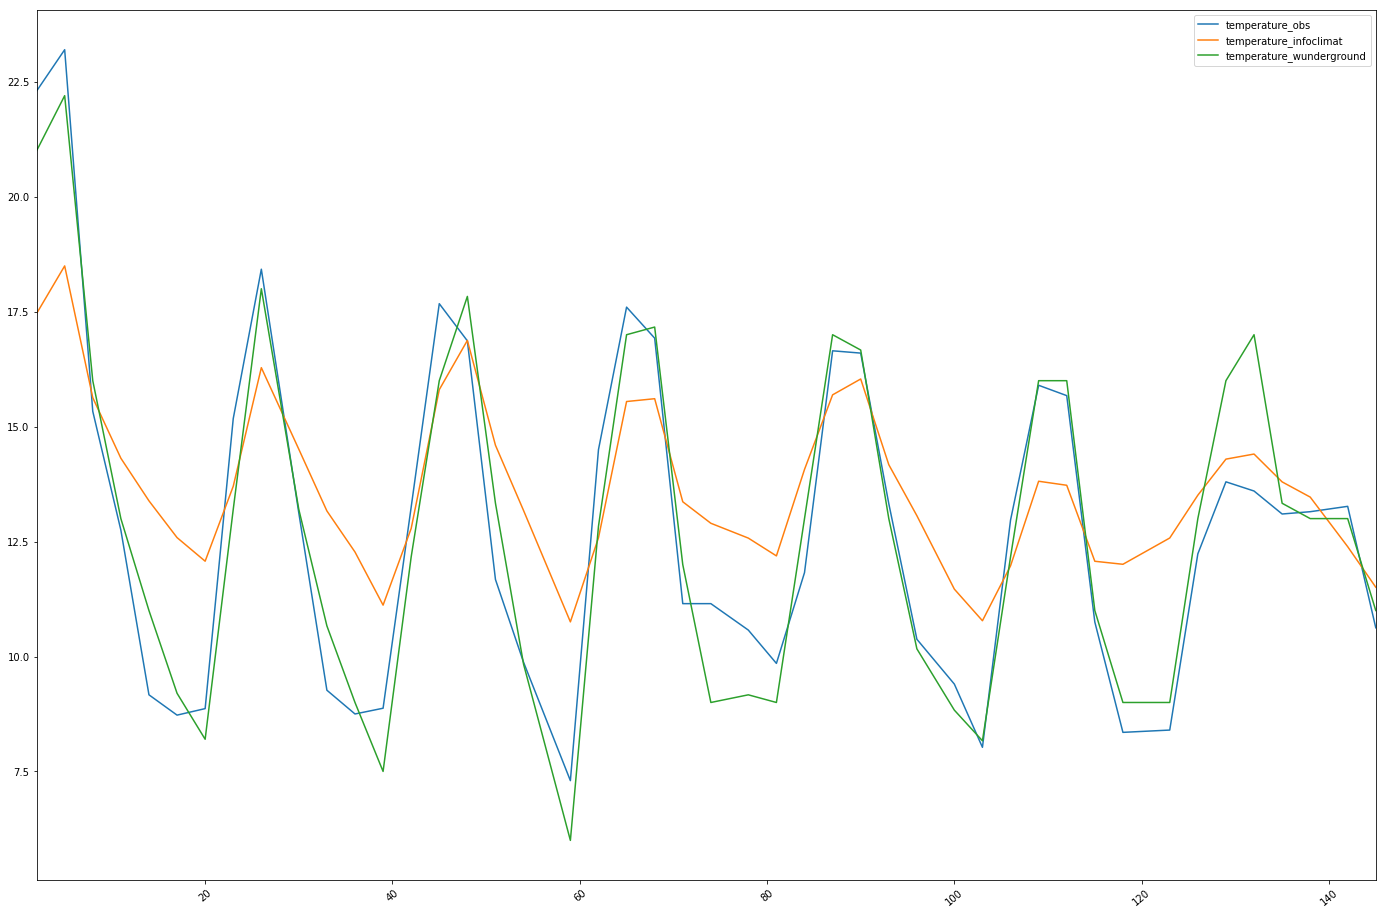

In [42]:
#  Vizualisation of the forecasters and observation temperature during one week 
plt.figure(figsize=(24,16))
prevs['temperature_obs'].plot()
#prevs['temperature_apiagro'].plot()
#prevs['temperature_darksky'].plot()
prevs['temperature_infoclimat'].plot()
#prevs['temperature_meteoconcept'].plot()
#prevs['temperature_openweathermap'].plot()
prevs['temperature_wunderground'].plot()
#prevs['temperature_weatherbit'].plot()
plt.legend()
plt.rcParams["font.size"] = "20"
_=plt.xticks(rotation=40) 

#### Humidity based dataset

In [43]:
asport_obs = pd.read_csv('technical_challenge_v9/Asport CAPRED-Observations.csv',sep = ";")
asport_obs = asport_obs.drop(['date', 'temperature', 'precipitation', 'station'],axis=1).dropna()
asport_obs["time"] = pd.to_datetime(asport_obs['time'], format='%d-%m-%Y %H:%M:%S')
asport_obs.sort_values(by='time')
asport_obs['time'] = asport_obs['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_obs.columns = ['humidity_obs','time']
asport_obs = asport_obs.groupby('time', as_index=False).mean()

asport_prev_apiagro = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Api-Agro.csv',sep = ";")
asport_prev_apiagro = asport_prev_apiagro.drop(['cloud_cover', 'date', 'temperature', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_apiagro["time"] = pd.to_datetime(asport_prev_apiagro['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_apiagro.sort_values(by='time')
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_apiagro.columns = ['humidity_apiagro','time'] 
asport_prev_apiagro = asport_prev_apiagro.groupby('time', as_index=False).mean()

asport_prev_darksky = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Dark Sky.csv',sep = ";")
asport_prev_darksky = asport_prev_darksky.drop(['cloud_cover', 'date', 'temperature', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_darksky["time"] = pd.to_datetime(asport_prev_darksky['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_darksky.sort_values(by='time')
asport_prev_darksky['time'] = asport_prev_darksky['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_darksky.columns = ['humidity_darksky','time'] 
asport_prev_darksky = asport_prev_darksky.groupby('time', as_index=False).mean()

asport_prev_infoclimat = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Infoclimat.csv',sep = ";")
asport_prev_infoclimat = asport_prev_infoclimat.drop(['cloud_cover', 'date', 'temperature', 'pressure', 'wind',
                                                      'wind_dir'],axis=1).dropna()
asport_prev_infoclimat["time"] = pd.to_datetime(asport_prev_infoclimat['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_infoclimat.sort_values(by='time')
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_infoclimat.columns = ['humidity_infoclimat','time'] 
asport_prev_infoclimat = asport_prev_infoclimat.groupby('time', as_index=False).mean()

asport_prev_openweathermap = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-OpenWeatherMap.csv',sep = ";")
asport_prev_openweathermap = asport_prev_openweathermap.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                              'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_openweathermap["time"] = pd.to_datetime(asport_prev_openweathermap['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_openweathermap.sort_values(by='time')
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_openweathermap.columns = ['humidity_openweathermap','time'] 
asport_prev_openweathermap = asport_prev_openweathermap.groupby('time', as_index=False).mean()

asport_prev_meteoconcept = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Meteo Concept.csv',sep = ";")
asport_prev_meteoconcept = asport_prev_meteoconcept.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_meteoconcept["time"] = pd.to_datetime(asport_prev_meteoconcept['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_meteoconcept.sort_values(by='time')
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_meteoconcept.columns = ['humidity_meteoconcept','time'] 
asport_prev_meteoconcept = asport_prev_meteoconcept.groupby('time', as_index=False).mean()

asport_prev_wunderground = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Wunderground.csv',sep = ";")
asport_prev_wunderground = asport_prev_wunderground.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_wunderground["time"] = pd.to_datetime(asport_prev_wunderground['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_wunderground.sort_values(by='time')
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_wunderground.columns = ['humidity_wunderground','time'] 
asport_prev_wunderground = asport_prev_wunderground.groupby('time', as_index=False).mean()

asport_prev_weatherbit = pd.read_csv('technical_challenge_v9/Asport CAPRED-Previsions-Weatherbit.csv',sep = ";")
asport_prev_weatherbit = asport_prev_weatherbit.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                      'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_weatherbit["time"] = pd.to_datetime(asport_prev_weatherbit['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_weatherbit.sort_values(by='time')
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_weatherbit.columns = ['humidity_weatherbit','time'] 
asport_prev_weatherbit  = asport_prev_weatherbit.groupby('time', as_index=False).mean()

#### Merge DataFrames in a single file

In [44]:
prevs2 = pd.merge(asport_obs,asport_prev_apiagro[['time', 'humidity_apiagro']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_darksky[['time', 'humidity_darksky']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_infoclimat[['time', 'humidity_infoclimat']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_meteoconcept[['time', 'humidity_meteoconcept']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_openweathermap[['time', 'humidity_openweathermap']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_wunderground[['time', 'humidity_wunderground']], how='left',on='time')

prevs2 = pd.merge(prevs2,asport_prev_weatherbit[['time', 'humidity_weatherbit']], how='left',on='time')

#### Description of the dataset with missing values

In [45]:
prevs2.describe()

,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
count,261.00000,261.000000,261.000000,83.000000,249.000000,83.000000,146.000000,261.000000
mean,62.63410,59.663492,56.822212,61.890595,63.397925,64.822732,62.467580,57.265805
std,14.96971,16.159069,14.940854,8.908274,16.508310,14.972534,16.278989,17.822096
min,30.75000,26.873776,29.500000,41.468750,30.500000,36.400000,31.400000,20.250000
25%,50.75000,47.756472,45.125000,56.340625,49.000000,53.121053,47.525000,43.500000
50%,63.00000,58.307137,53.666667,60.440000,63.000000,62.052632,65.266667,56.250000
75%,73.00000,73.142500,68.000000,67.320867,76.000000,76.478947,75.000000,70.250000
max,90.75000,93.800721,91.000000,81.325000,97.000000,97.055556,92.500000,96.250000


In [46]:
# Delete missing values
prevs2 = prevs2.dropna()

In [47]:
# number of rows
len(prevs2)
print(prevs2)

                   time  humidity_obs  humidity_apiagro  humidity_darksky  \
2   2019-02-28 12:00:00     35.750000         40.839317         37.777778   
5   2019-02-28 15:00:00     32.333333         32.518607         32.000000   
8   2019-02-28 18:00:00     50.333333         46.091677         41.888889   
11  2019-02-28 21:00:00     55.250000         52.912793         48.750000   
14  2019-03-01 00:00:00     66.000000         60.405898         56.888889   
17  2019-03-01 03:00:00     70.500000         61.872089         64.875000   
20  2019-03-01 06:00:00     70.666667         65.089824         68.111111   
23  2019-03-01 09:00:00     50.750000         54.578627         52.625000   
26  2019-03-01 12:00:00     40.500000         38.431845         38.333333   
30  2019-03-01 18:00:00     53.750000         52.276281         44.000000   
33  2019-03-01 21:00:00     65.000000         61.008970         51.500000   
36  2019-03-02 00:00:00     65.250000         64.428156         59.111111   

In [31]:
# Sort value by time with hour granularity (ascending order by default)
prevs2.sort_values(by='time')

,time,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
0,01-03-2019 00,66.000000,60.405898,56.888889,63.403333,69.000000,60.058824,65.200000,55.500
3,01-03-2019 03,70.500000,61.872089,64.875000,65.280000,77.000000,65.388889,68.800000,59.375
6,01-03-2019 06,70.666667,65.089824,68.111111,66.226667,80.333333,72.833333,74.800000,66.125
9,01-03-2019 09,50.750000,54.578627,52.625000,59.826667,60.000000,61.473684,56.800000,51.625
12,01-03-2019 12,40.500000,38.431845,38.333333,50.660000,41.666667,57.473684,38.400000,34.000
16,01-03-2019 18,53.750000,52.276281,44.000000,58.063333,55.000000,45.894737,51.000000,46.000
19,01-03-2019 21,65.000000,61.008970,51.500000,60.293333,61.500000,51.526316,59.333333,61.500
22,02-03-2019 00,65.250000,64.428156,59.111111,62.896667,68.500000,64.411765,69.666667,56.875
25,02-03-2019 06,64.000000,58.608804,67.666667,64.680645,68.666667,80.411765,69.666667,59.875
28,02-03-2019 09,55.500000,54.381201,53.250000,59.841935,56.666667,60.277778,56.500000,47.625


In [32]:
# Description of each forcaster's values
prevs2.describe()

,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,63.099638,60.786453,58.167874,63.839116,63.929348,66.393323,62.039855,57.029891
std,15.641367,16.628875,15.739747,9.000237,15.123772,15.333538,16.068360,17.157647
min,32.333333,32.518607,32.000000,46.160000,32.000000,45.894737,33.000000,22.250000
25%,50.083333,44.765478,44.083333,58.290242,53.950000,53.197368,46.333333,42.625000
50%,64.666667,59.842011,57.194444,62.381653,62.625000,61.763158,65.266667,57.375000
75%,75.750000,75.608632,71.572917,71.528352,76.875000,78.197368,74.600000,70.781250
max,89.000000,93.168692,89.750000,81.325000,87.000000,97.055556,91.333333,87.500000


In [33]:
# Calculate RMSE = Determination of the best forecaster with lowest RMSE value 
ApiAgro = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_apiagro'])
DarkSky = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_darksky'])
Infoclimat = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_infoclimat'])
OpenWeatherMap = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_openweathermap'])
Wunderground = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_wunderground'])
MeteoConcept = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_meteoconcept'])
Weatherbit = mean_squared_error(prevs2['humidity_obs'], prevs2['humidity_weatherbit'])

In [34]:
# Print RMSE for each forecaster in a DataFrame

RMSE_Asport_H = {'ApiAgro': [ApiAgro], 
        'DarkSky': [DarkSky], 
        'Infoclimat': [Infoclimat], 
        'OpenWeatherMap': [OpenWeatherMap], 
        'Wunderground': [Wunderground], 
        'MeteoConcept': [MeteoConcept], 
        'Weatherbit': [Weatherbit]}

RMSE_Asport_H = pd.DataFrame(RMSE_Asport_H)
print(RMSE_Asport_H)

    ApiAgro    DarkSky  Infoclimat  OpenWeatherMap  Wunderground  \
0  22.52506  75.197103   66.918898      144.175506     34.396141   

   MeteoConcept  Weatherbit  
0      26.21471   54.695765  


In [35]:
prevs2.set_index('time')

,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
time,,,,,,,,
01-03-2019 00,66.000000,60.405898,56.888889,63.403333,69.000000,60.058824,65.200000,55.500
01-03-2019 03,70.500000,61.872089,64.875000,65.280000,77.000000,65.388889,68.800000,59.375
01-03-2019 06,70.666667,65.089824,68.111111,66.226667,80.333333,72.833333,74.800000,66.125
01-03-2019 09,50.750000,54.578627,52.625000,59.826667,60.000000,61.473684,56.800000,51.625
01-03-2019 12,40.500000,38.431845,38.333333,50.660000,41.666667,57.473684,38.400000,34.000
01-03-2019 18,53.750000,52.276281,44.000000,58.063333,55.000000,45.894737,51.000000,46.000
01-03-2019 21,65.000000,61.008970,51.500000,60.293333,61.500000,51.526316,59.333333,61.500
02-03-2019 00,65.250000,64.428156,59.111111,62.896667,68.500000,64.411765,69.666667,56.875
02-03-2019 06,64.000000,58.608804,67.666667,64.680645,68.666667,80.411765,69.666667,59.875


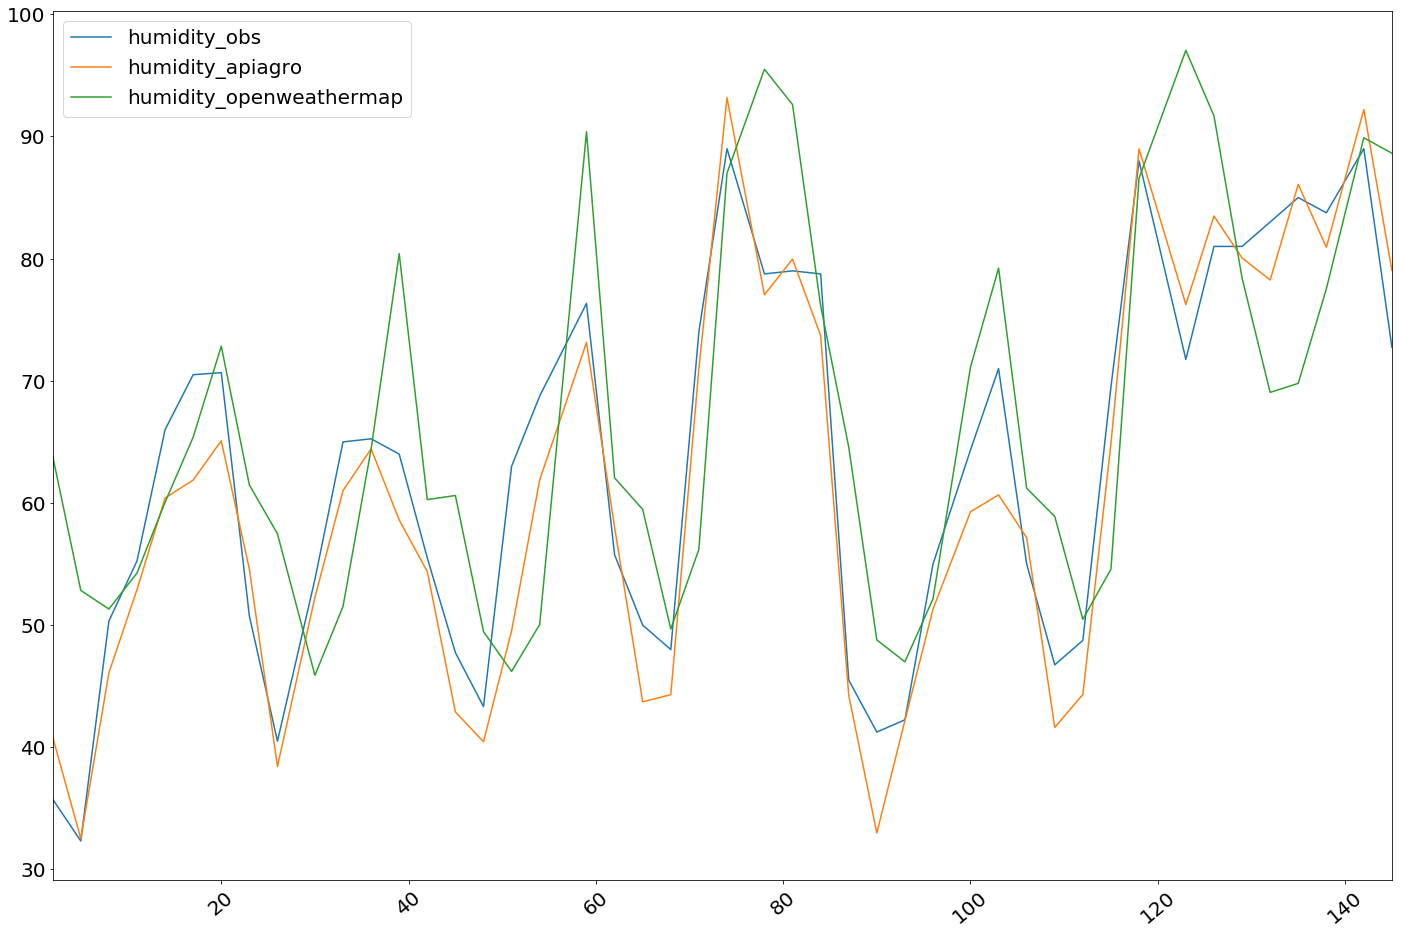

In [48]:
#  Vizualisation of the forecasters and observation temperature during one week 
plt.figure(figsize=(24,16))
prevs2['humidity_obs'].plot()
prevs2['humidity_apiagro'].plot()
#prevs2['humidity_darksky'].plot()
#prevs2['humidity_infoclimat'].plot()
#prevs2['temperature_meteoconcept'].plot()
prevs2['humidity_openweathermap'].plot()
#prevs2['humidity_wunderground'].plot()
#prevs2['humidity_weatherbit'].plot()
plt.legend()
plt.rcParams["font.size"] = "20"
_=plt.xticks(rotation=40) 

# Forecasters Analysis La Tuilerie

#### Temperature based dataset

In [50]:
tuilerie_obs = pd.read_csv('technical_challenge_v9/La Tuilerie-Observations.csv',sep = ";")
tuilerie_obs = tuilerie_obs.drop(['date', 'humidity', 'precipitation', 'station'],axis=1).dropna()
tuilerie_obs["time"] = pd.to_datetime(tuilerie_obs['time'], format='%d-%m-%Y %H:%M:%S')
tuilerie_obs.sort_values(by='time')
tuilerie_obs['time'] = tuilerie_obs['time'].apply(lambda x: x.replace(minute=0, second=0))
tuilerie_obs.columns = ['temperature_obs','time']
tuilerie_obs = tuilerie_obs.groupby('time', as_index=False).mean()

asport_prev_apiagro = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Api-Agro.csv',sep = ";")
asport_prev_apiagro = asport_prev_apiagro.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_apiagro["time"] = pd.to_datetime(asport_prev_apiagro['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_apiagro.sort_values(by='time')
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_apiagro.columns = ['temperature_apiagro','time'] 
asport_prev_apiagro = asport_prev_apiagro.groupby('time', as_index=False).mean()

asport_prev_darksky = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Dark Sky.csv',sep = ";")
asport_prev_darksky = asport_prev_darksky.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_darksky["time"] = pd.to_datetime(asport_prev_darksky['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_darksky.sort_values(by='time')
asport_prev_darksky['time'] = asport_prev_darksky['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_darksky.columns = ['temperature_darksky','time'] 
asport_prev_darksky = asport_prev_darksky.groupby('time', as_index=False).mean()

asport_prev_infoclimat = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Infoclimat.csv',sep = ";")
asport_prev_infoclimat = asport_prev_infoclimat.drop(['cloud_cover', 'date', 'humidity', 'pressure', 'wind',
                                                      'wind_dir'],axis=1).dropna()
asport_prev_infoclimat["time"] = pd.to_datetime(asport_prev_infoclimat['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_infoclimat.sort_values(by='time')
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_infoclimat.columns = ['temperature_infoclimat','time'] 
asport_prev_infoclimat = asport_prev_infoclimat.groupby('time', as_index=False).mean()

asport_prev_openweathermap = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-OpenWeatherMap.csv',sep = ";")
asport_prev_openweathermap = asport_prev_openweathermap.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                              'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_openweathermap["time"] = pd.to_datetime(asport_prev_openweathermap['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_openweathermap.sort_values(by='time')
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_openweathermap.columns = ['temperature_openweathermap','time'] 
asport_prev_openweathermap = asport_prev_openweathermap.groupby('time', as_index=False).mean()

asport_prev_meteoconcept = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Meteo Concept.csv',sep = ";")
asport_prev_meteoconcept = asport_prev_meteoconcept.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_meteoconcept["time"] = pd.to_datetime(asport_prev_meteoconcept['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_meteoconcept.sort_values(by='time')
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_meteoconcept.columns = ['temperature_meteoconcept','time'] 
asport_prev_meteoconcept = asport_prev_meteoconcept.groupby('time', as_index=False).mean()

asport_prev_wunderground = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Wunderground.csv',sep = ";")
asport_prev_wunderground = asport_prev_wunderground.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_wunderground["time"] = pd.to_datetime(asport_prev_wunderground['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_wunderground.sort_values(by='time')
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_wunderground.columns = ['temperature_wunderground','time'] 
asport_prev_wunderground = asport_prev_wunderground.groupby('time', as_index=False).mean()

asport_prev_weatherbit = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Weatherbit.csv',sep = ";")
asport_prev_weatherbit = asport_prev_weatherbit.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                      'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_weatherbit["time"] = pd.to_datetime(asport_prev_weatherbit['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_weatherbit.sort_values(by='time')
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_weatherbit.columns = ['temperature_weatherbit','time'] 
asport_prev_weatherbit  = asport_prev_weatherbit.groupby('time', as_index=False).mean()

#### Merge DataFrames in a single file

In [51]:
prevs3 = pd.merge(tuilerie_obs,asport_prev_apiagro[['time', 'temperature_apiagro']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_darksky[['time', 'temperature_darksky']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_infoclimat[['time', 'temperature_infoclimat']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_meteoconcept[['time', 'temperature_meteoconcept']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_openweathermap[['time', 'temperature_openweathermap']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_wunderground[['time', 'temperature_wunderground']], how='left',on='time')

prevs3 = pd.merge(prevs3,asport_prev_weatherbit[['time', 'temperature_weatherbit']], how='left',on='time')

#### Description of the dataset with missing values

In [52]:
prevs3.describe()

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
count,259.000000,259.000000,259.000000,82.000000,247.000000,82.000000,144.000000,259.000000
mean,11.639897,11.927902,12.917872,11.336055,12.030904,11.953634,12.538657,12.254295
std,4.770209,3.424200,4.025052,3.515640,3.803825,4.449200,3.771965,3.794707
min,0.550000,3.951625,3.588750,3.940625,2.000000,0.760000,6.000000,3.612500
25%,8.258333,9.467913,9.768264,8.450000,9.200000,8.743250,9.000000,9.531250
50%,11.600000,11.764530,12.863750,10.904687,12.000000,11.887500,12.416667,12.225000
75%,15.391667,14.385195,15.989375,13.675781,15.000000,15.048125,15.700000,15.168750
max,24.566667,21.550226,23.125000,19.806667,22.000000,21.000526,22.800000,23.525000


In [40]:
# Api-Agro             0% missing value
# DarkSky              0% missing value
# Infoclimat          68.3% missing value 
# Meteoconcept         4.6% missing value
# Openweathermap      68.3% missing value
# Wunderground        44.4% missing value
# Weatherbit           0% missing value 

In [53]:
# Delete missing values
prevs3 = prevs3.dropna()

In [54]:
# number of rows
len(prevs3)

45

In [55]:
# Sort value by time with hour granularity (ascending order by default)
prevs3.sort_values(by='time')

,time,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
2,2019-02-28 12:00:00,24.200000,19.618878,21.073333,18.980000,21.000000,19.224737,20.800000,21.5125
5,2019-02-28 15:00:00,24.000000,21.111588,22.853750,19.806667,21.500000,21.000526,22.200000,22.9500
8,2019-02-28 18:00:00,13.675000,15.733094,17.144444,13.973333,16.000000,15.432105,15.800000,16.1375
11,2019-02-28 21:00:00,10.900000,12.458475,13.771250,11.626667,12.000000,11.854211,12.200000,13.2500
15,2019-03-01 03:00:00,5.775000,9.781654,9.917500,9.206667,8.000000,7.065556,9.000000,9.7625
18,2019-03-01 06:00:00,7.050000,9.284342,8.855556,8.266667,6.000000,5.448333,7.833333,8.7250
21,2019-03-01 09:00:00,15.450000,12.727116,13.535000,12.686667,12.000000,13.333158,13.166667,13.5750
24,2019-03-01 12:00:00,20.425000,17.252375,18.145556,16.386667,16.666667,18.345263,17.833333,18.1250
28,2019-03-01 18:00:00,11.925000,13.737493,14.883333,12.133333,12.000000,14.532105,13.166667,12.9125
31,2019-03-01 21:00:00,7.975000,10.690009,11.756250,10.203333,10.000000,9.551579,10.500000,9.9250


In [44]:
# Calculate RMSE = Determination of the best forecaster with lowest RMSE value 
ApiAgro = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_apiagro'])
DarkSky = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_darksky'])
Infoclimat = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_infoclimat'])
OpenWeatherMap = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_openweathermap'])
Wunderground = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_wunderground'])
MeteoConcept = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_meteoconcept'])
Weatherbit = mean_squared_error(prevs3['temperature_obs'], prevs3['temperature_weatherbit'])

In [45]:
# Print RMSE for each forecaster in a DataFrame

RMSE_Asport_T = {'ApiAgro': [ApiAgro], 
        'DarkSky': [DarkSky], 
        'Infoclimat': [Infoclimat], 
        'OpenWeatherMap': [OpenWeatherMap], 
        'Wunderground': [Wunderground], 
        'MeteoConcept': [MeteoConcept], 
        'Weatherbit': [Weatherbit]}

RMSE_Asport_T = pd.DataFrame(RMSE_Asport_T)
print(RMSE_Asport_T)

    ApiAgro   DarkSky  Infoclimat  OpenWeatherMap  Wunderground  MeteoConcept  \
0  5.595244  5.988738    4.918684        5.436453      3.555319      4.480171   

   Weatherbit  
0    3.542779  


In [46]:
prevs3['time'] = pd.to_datetime(prevs3.time)

In [47]:
prevs3.set_index('time')

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
time,,,,,,,,
2019-01-03 03:00:00,5.775000,9.781654,9.917500,9.206667,8.000000,7.065556,9.000000,9.7625
2019-01-03 06:00:00,7.050000,9.284342,8.855556,8.266667,6.000000,5.448333,7.833333,8.7250
2019-01-03 09:00:00,15.450000,12.727116,13.535000,12.686667,12.000000,13.333158,13.166667,13.5750
2019-01-03 12:00:00,20.425000,17.252375,18.145556,16.386667,16.666667,18.345263,17.833333,18.1250
2019-01-03 18:00:00,11.925000,13.737493,14.883333,12.133333,12.000000,14.532105,13.166667,12.9125
2019-01-03 21:00:00,7.975000,10.690009,11.756250,10.203333,10.000000,9.551579,10.500000,9.9250
2019-02-03 00:00:00,6.425000,8.314908,9.817778,9.160000,8.500000,6.334118,8.833333,8.9000
2019-02-03 06:00:00,7.250000,7.992733,7.020000,7.427419,6.666667,3.653889,7.500000,6.6125
2019-02-03 09:00:00,14.450000,11.662017,12.093750,11.433871,11.666667,11.402105,12.000000,12.1125


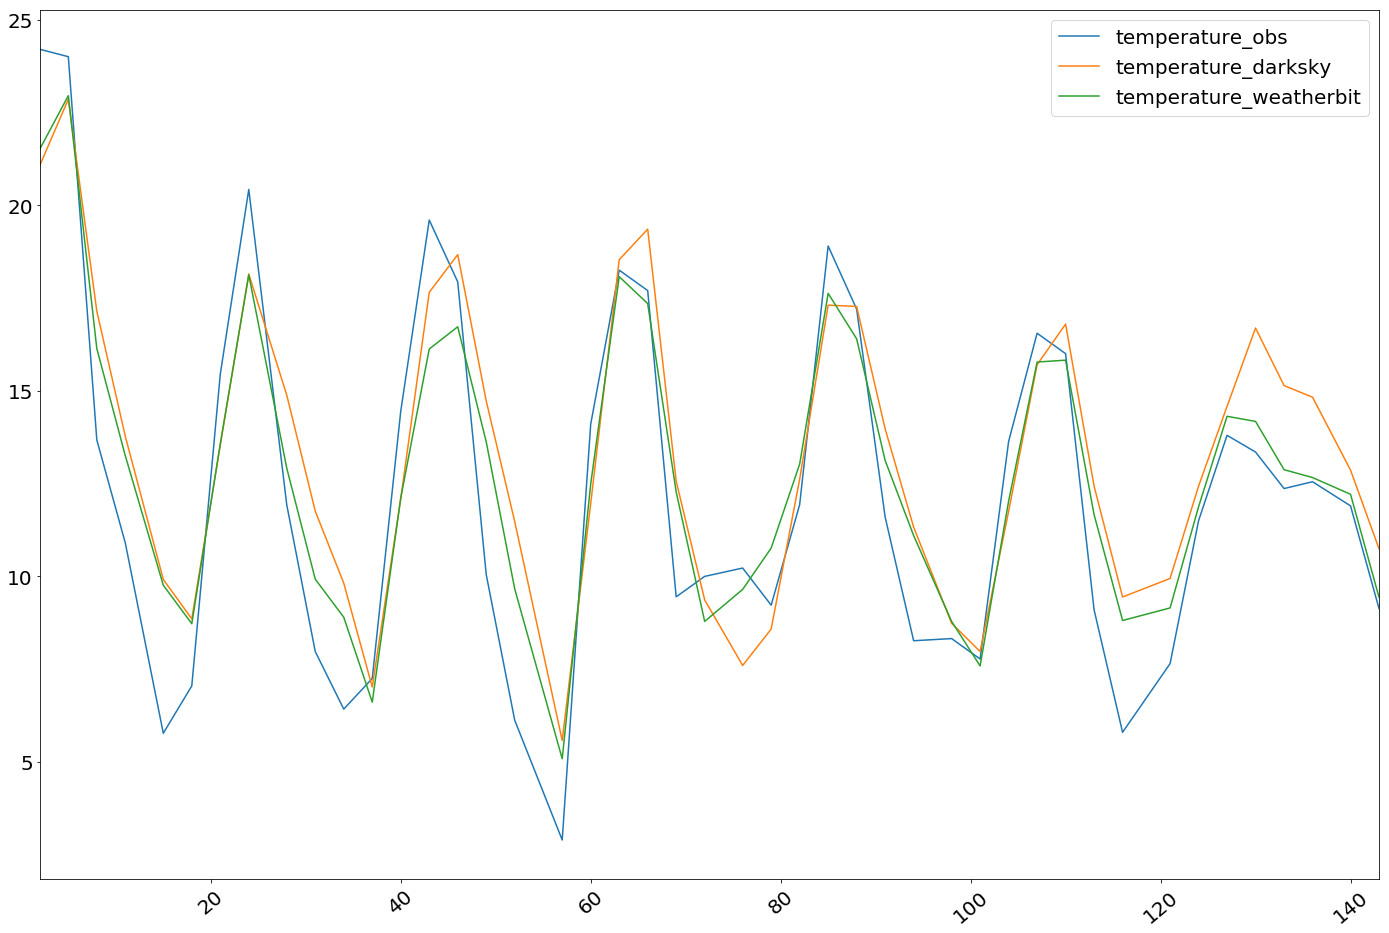

In [57]:
#  Vizualisation of the forecasters and observation temperature during one week 

plt.figure(figsize=(24,16))
prevs3['temperature_obs'].plot()
#prevs3['temperature_apiagro'].plot()
prevs3['temperature_darksky'].plot()
#prevs3['temperature_infoclimat'].plot()
#prevs3['temperature_meteoconcept'].plot()
#prevs3['temperature_openweathermap'].plot()
#prevs3['temperature_wunderground'].plot()
prevs3['temperature_weatherbit'].plot()
plt.legend()
plt.rcParams["font.size"] = "20"
_=plt.xticks(rotation=40) 

#### Humidity based dataset

In [58]:
tuilerie_obs = pd.read_csv('technical_challenge_v9/La Tuilerie-Observations.csv',sep = ";")
tuilerie_obs = tuilerie_obs.drop(['date', 'temperature', 'precipitation', 'station'],axis=1).dropna()
tuilerie_obs["time"] = pd.to_datetime(tuilerie_obs['time'], format='%d-%m-%Y %H:%M:%S')
tuilerie_obs.sort_values(by='time')
tuilerie_obs['time'] = tuilerie_obs['time'].apply(lambda x: x.replace(minute=0, second=0))
tuilerie_obs.columns = ['humidity_obs','time']
tuilerie_obs = tuilerie_obs.groupby('time', as_index=False).mean()

asport_prev_apiagro = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Api-Agro.csv',sep = ";")
asport_prev_apiagro = asport_prev_apiagro.drop(['cloud_cover', 'date', 'temperature', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_apiagro["time"] = pd.to_datetime(asport_prev_apiagro['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_apiagro.sort_values(by='time')
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_apiagro.columns = ['humidity_apiagro','time'] 
asport_prev_apiagro = asport_prev_apiagro.groupby('time', as_index=False).mean()

asport_prev_darksky = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Dark Sky.csv',sep = ";")
asport_prev_darksky = asport_prev_darksky.drop(['cloud_cover', 'date', 'temperature', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_darksky["time"] = pd.to_datetime(asport_prev_darksky['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_darksky.sort_values(by='time')
asport_prev_darksky['time'] = asport_prev_darksky['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_darksky.columns = ['humidity_darksky','time'] 
asport_prev_darksky = asport_prev_darksky.groupby('time', as_index=False).mean()

asport_prev_infoclimat = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Infoclimat.csv',sep = ";")
asport_prev_infoclimat = asport_prev_infoclimat.drop(['cloud_cover', 'date', 'temperature', 'pressure', 'wind',
                                                      'wind_dir'],axis=1).dropna()
asport_prev_infoclimat["time"] = pd.to_datetime(asport_prev_infoclimat['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_infoclimat.sort_values(by='time')
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_infoclimat.columns = ['humidity_infoclimat','time'] 
asport_prev_infoclimat = asport_prev_infoclimat.groupby('time', as_index=False).mean()

asport_prev_openweathermap = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-OpenWeatherMap.csv',sep = ";")
asport_prev_openweathermap = asport_prev_openweathermap.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                              'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_openweathermap["time"] = pd.to_datetime(asport_prev_openweathermap['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_openweathermap.sort_values(by='time')
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_openweathermap.columns = ['humidity_openweathermap','time'] 
asport_prev_openweathermap = asport_prev_openweathermap.groupby('time', as_index=False).mean()

asport_prev_meteoconcept = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Meteo Concept.csv',sep = ";")
asport_prev_meteoconcept = asport_prev_meteoconcept.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_meteoconcept["time"] = pd.to_datetime(asport_prev_meteoconcept['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_meteoconcept.sort_values(by='time')
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_meteoconcept.columns = ['humidity_meteoconcept','time'] 
asport_prev_meteoconcept = asport_prev_meteoconcept.groupby('time', as_index=False).mean()

asport_prev_wunderground = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Wunderground.csv',sep = ";")
asport_prev_wunderground = asport_prev_wunderground.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_wunderground["time"] = pd.to_datetime(asport_prev_wunderground['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_wunderground.sort_values(by='time')
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_wunderground.columns = ['humidity_wunderground','time'] 
asport_prev_wunderground = asport_prev_wunderground.groupby('time', as_index=False).mean()

asport_prev_weatherbit = pd.read_csv('technical_challenge_v9/La Tuilerie-Previsions-Weatherbit.csv',sep = ";")
asport_prev_weatherbit = asport_prev_weatherbit.drop(['cloud_cover', 'date', 'temperature', 'latitude_r',
                                                      'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_weatherbit["time"] = pd.to_datetime(asport_prev_weatherbit['time'], format='%d-%m-%Y %H:%M:%S')
asport_prev_weatherbit.sort_values(by='time')
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].apply(lambda x: x.replace(minute=0, second=0))
asport_prev_weatherbit.columns = ['humidity_weatherbit','time'] 
asport_prev_weatherbit  = asport_prev_weatherbit.groupby('time', as_index=False).mean()

#### Merge DataFrames in a single file

In [59]:
prevs4 = pd.merge(tuilerie_obs,asport_prev_apiagro[['time', 'humidity_apiagro']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_darksky[['time', 'humidity_darksky']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_infoclimat[['time', 'humidity_infoclimat']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_meteoconcept[['time', 'humidity_meteoconcept']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_openweathermap[['time', 'humidity_openweathermap']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_wunderground[['time', 'humidity_wunderground']], how='left',on='time')

prevs4 = pd.merge(prevs4,asport_prev_weatherbit[['time', 'humidity_weatherbit']], how='left',on='time')

#### Description of the dataset with missing values

In [60]:
prevs4.describe()

,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
count,259.000000,259.000000,259.000000,82.000000,247.000000,82.000000,144.000000,259.000000
mean,64.691763,60.296453,55.826791,61.902029,60.490553,64.817719,62.195949,58.494691
std,16.989325,16.539268,15.310773,12.036437,16.425205,15.052714,16.336885,18.420418
min,29.333333,27.139401,28.375000,36.675000,28.500000,36.400000,31.200000,20.375000
25%,50.000000,47.610366,43.562500,53.149375,47.000000,52.981579,47.125000,42.937500
50%,66.250000,59.094017,52.375000,62.378125,59.000000,62.800000,65.333333,58.875000
75%,78.666667,74.829420,67.437500,71.384531,72.000000,76.650000,75.166667,72.312500
max,94.250000,94.420709,90.375000,86.900000,96.000000,97.157895,92.500000,96.250000


In [61]:
# Delete missing values
prevs4 = prevs4.dropna()

In [62]:
# number of rows
len(prevs4)

45

In [63]:
# Sort value by time with hour granularity (ascending order by default)
prevs4.sort_values(by='time')

,time,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
2,2019-02-28 12:00:00,32.333333,42.428603,35.777778,39.433333,31.000000,63.842105,36.800000,27.625
5,2019-02-28 15:00:00,29.333333,33.442714,30.500000,38.053333,30.500000,52.842105,32.600000,22.750
8,2019-02-28 18:00:00,54.000000,46.636320,40.333333,53.260000,41.666667,51.315789,45.600000,41.750
11,2019-02-28 21:00:00,61.000000,52.719043,47.500000,60.943333,53.000000,54.263158,53.200000,50.375
15,2019-03-01 03:00:00,80.000000,62.215839,63.875000,71.536667,72.000000,65.388889,68.500000,64.000
18,2019-03-01 06:00:00,77.000000,65.199199,67.111111,73.613333,75.000000,72.833333,74.666667,71.000
21,2019-03-01 09:00:00,51.750000,54.740085,51.500000,58.523333,59.000000,61.473684,56.166667,49.625
24,2019-03-01 12:00:00,37.250000,38.592560,36.444444,44.943333,40.666667,57.473684,38.500000,33.750
28,2019-03-01 18:00:00,56.500000,52.160210,42.333333,58.126667,52.000000,45.894737,50.666667,50.375
31,2019-03-01 21:00:00,67.250000,60.615220,50.375000,64.600000,60.000000,51.526316,59.500000,64.750


In [64]:
# Description of each forcaster's values
prevs4.describe()

,humidity_obs,humidity_apiagro,humidity_darksky,humidity_infoclimat,humidity_meteoconcept,humidity_openweathermap,humidity_wunderground,humidity_weatherbit
count,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,64.598148,60.820540,57.155556,62.843408,62.229630,66.419092,61.746667,58.186111
std,18.028914,16.745968,16.294500,12.378893,15.434124,15.484525,16.205013,17.726289
min,29.333333,32.922662,30.500000,38.053333,30.500000,45.894737,32.600000,22.750000
25%,47.000000,45.244754,42.333333,53.260000,51.400000,52.842105,45.600000,42.750000
50%,68.000000,59.978408,56.500000,64.600000,62.000000,62.000000,63.500000,61.000000
75%,80.000000,77.573804,71.555556,74.009677,75.000000,78.000000,74.666667,71.000000
max,94.000000,92.631192,89.250000,80.396970,86.750000,97.157895,92.000000,86.375000


In [65]:
# Calculate RMSE = Determination of the best forecaster with lowest RMSE value 
ApiAgro = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_apiagro'])
DarkSky = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_darksky'])
Infoclimat = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_infoclimat'])
OpenWeatherMap = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_openweathermap'])
Wunderground = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_wunderground'])
MeteoConcept = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_meteoconcept'])
Weatherbit = mean_squared_error(prevs4['humidity_obs'], prevs4['humidity_weatherbit'])

In [66]:
# Print RMSE for each forecaster in a DataFrame

RMSE_Asport_H = {'ApiAgro': [ApiAgro], 
        'DarkSky': [DarkSky], 
        'Infoclimat': [Infoclimat], 
        'OpenWeatherMap': [OpenWeatherMap], 
        'Wunderground': [Wunderground], 
        'MeteoConcept': [MeteoConcept], 
        'Weatherbit': [Weatherbit]}

RMSE_Asport_H = pd.DataFrame(RMSE_Asport_H)
print(RMSE_Asport_H)

     ApiAgro     DarkSky  Infoclimat  OpenWeatherMap  Wunderground  \
0  57.621556  133.506293   66.378934      196.202957     50.871488   

   MeteoConcept  Weatherbit  
0     54.269932   70.606597  


In [58]:
prevs4['time'] = pd.to_datetime(prevs4.time)

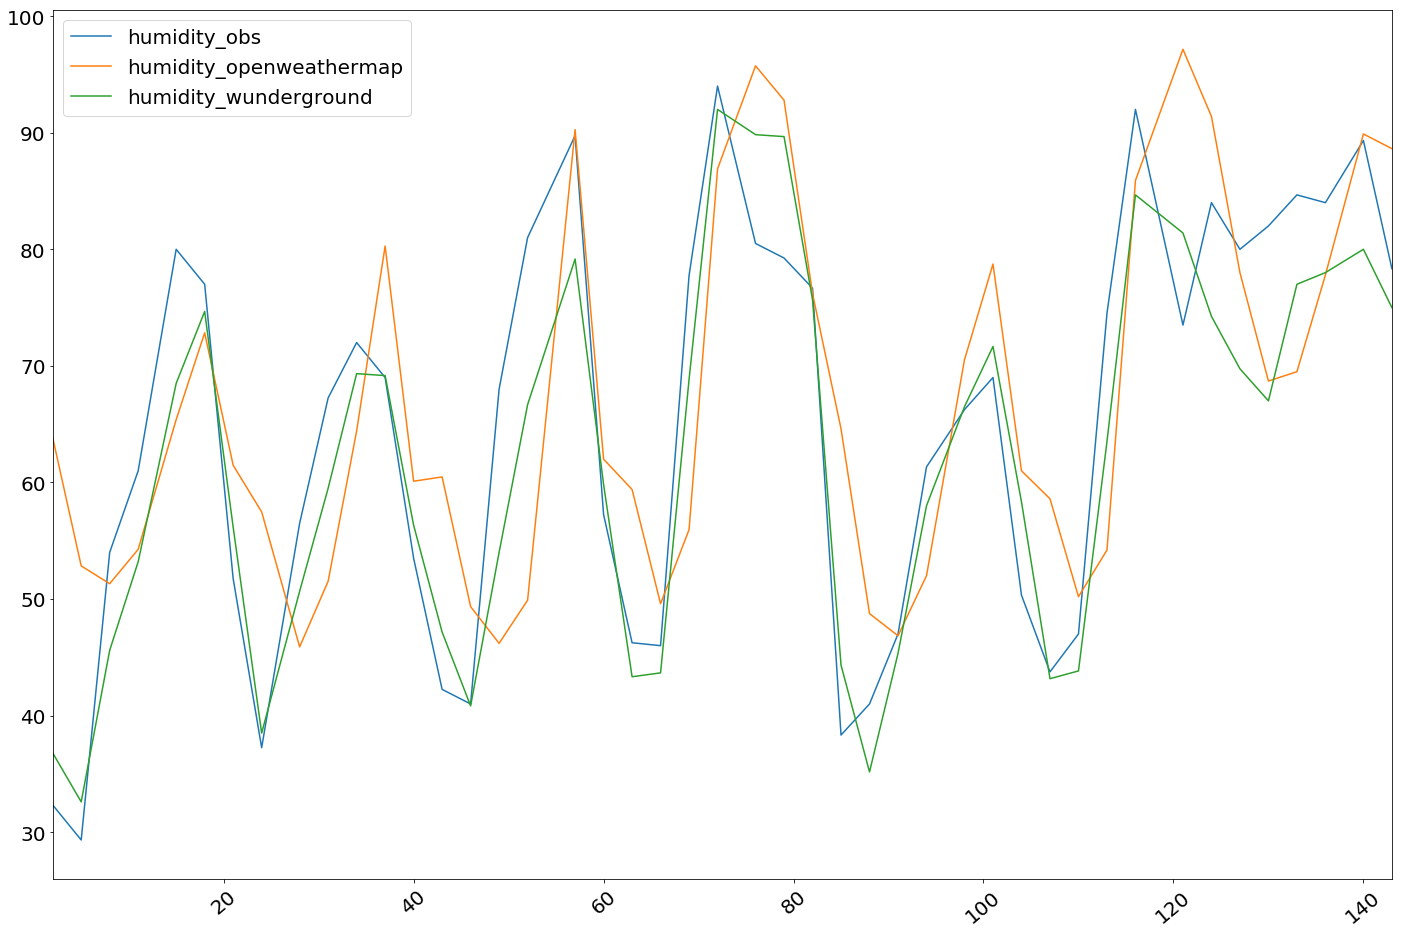

In [67]:
#  Vizualisation of the forecasters and observation temperature during one week 
plt.figure(figsize=(24,16))
prevs4['humidity_obs'].plot()
#prevs4['humidity_apiagro'].plot()
#prevs4['humidity_darksky'].plot()
#prevs4['humidity_infoclimat'].plot()
#prevs4['temperature_meteoconcept'].plot()
prevs4['humidity_openweathermap'].plot()
prevs4['humidity_wunderground'].plot()
#prevs4['humidity_weatherbit'].plot()
plt.legend()
plt.rcParams["font.size"] = "20"
_=plt.xticks(rotation=40) 

# Forecasters Analysis Campuget

#### Temperature based dataset

In [60]:
campuget_obs = pd.read_csv('technical_challenge_v9/Campuget 210-Observations.csv',sep = ";")
campuget_obs = campuget_obs.drop(['date', 'humidity', 'precipitation', 'station'],axis=1).dropna()
campuget_obs['time'] = campuget_obs['time'].astype('datetime64[ns]')
campuget_obs['time'] = campuget_obs['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
campuget_obs.columns = ['temperature_obs','time']
campuget_obs = campuget_obs.groupby('time', as_index=False).mean()

asport_prev_apiagro = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Api-Agro.csv',sep = ";")
asport_prev_apiagro = asport_prev_apiagro.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].astype('datetime64[ns]')
asport_prev_apiagro['time'] = asport_prev_apiagro['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_apiagro.columns = ['temperature_apiagro','time'] 
asport_prev_apiagro = asport_prev_apiagro.groupby('time', as_index=False).mean()

asport_prev_darksky = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Dark Sky.csv',sep = ";")
asport_prev_darksky = asport_prev_darksky.drop(['cloud_cover', 'date', 'humidity', 'latitude_r', 'longitude_r',
                                                'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_darksky['time'] = asport_prev_darksky['time'].astype('datetime64[ns]')
asport_prev_darksky['time'] = asport_prev_darksky['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_darksky.columns = ['temperature_darksky','time'] 
asport_prev_darksky = asport_prev_darksky.groupby('time', as_index=False).mean()

asport_prev_infoclimat = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Infoclimat.csv',sep = ";")
asport_prev_infoclimat = asport_prev_infoclimat.drop(['cloud_cover', 'date', 'humidity', 'pressure', 'wind',
                                                      'wind_dir'],axis=1).dropna()
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].astype('datetime64[ns]')
asport_prev_infoclimat['time'] = asport_prev_infoclimat['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_infoclimat.columns = ['temperature_infoclimat','time'] 
asport_prev_infoclimat = asport_prev_infoclimat.groupby('time', as_index=False).mean()

asport_prev_openweathermap = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-OpenWeatherMap.csv',sep = ";")
asport_prev_openweathermap = asport_prev_openweathermap.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                              'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].astype('datetime64[ns]')
asport_prev_openweathermap['time'] = asport_prev_openweathermap['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_openweathermap.columns = ['temperature_openweathermap','time'] 
asport_prev_openweathermap = asport_prev_openweathermap.groupby('time', as_index=False).mean()

asport_prev_meteoconcept = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Meteo Concept.csv',sep = ";")
asport_prev_meteoconcept = asport_prev_meteoconcept.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].astype('datetime64[ns]')
asport_prev_meteoconcept['time'] = asport_prev_meteoconcept['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_meteoconcept.columns = ['temperature_meteoconcept','time'] 
asport_prev_meteoconcept = asport_prev_meteoconcept.groupby('time', as_index=False).mean()

asport_prev_wunderground = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Wunderground.csv',sep = ";")
asport_prev_wunderground = asport_prev_wunderground.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                          'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].astype('datetime64[ns]')
asport_prev_wunderground['time'] = asport_prev_wunderground['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_wunderground.columns = ['temperature_wunderground','time'] 
asport_prev_wunderground = asport_prev_wunderground.groupby('time', as_index=False).mean()

asport_prev_weatherbit = pd.read_csv('technical_challenge_v9/Campuget 210-Previsions-Weatherbit.csv',sep = ";")
asport_prev_weatherbit = asport_prev_weatherbit.drop(['cloud_cover', 'date', 'humidity', 'latitude_r',
                                                      'longitude_r', 'pressure', 'wind', 'wind_dir'],axis=1).dropna()
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].astype('datetime64[ns]')
asport_prev_weatherbit['time'] = asport_prev_weatherbit['time'].apply(lambda x: x.strftime('%m-%d-%Y %H'))
asport_prev_weatherbit.columns = ['temperature_weatherbit','time'] 
asport_prev_weatherbit  = asport_prev_weatherbit.groupby('time', as_index=False).mean()

In [61]:
prevs5 = pd.merge(campuget_obs,asport_prev_apiagro[['time', 'temperature_apiagro']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_darksky[['time', 'temperature_darksky']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_infoclimat[['time', 'temperature_infoclimat']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_meteoconcept[['time', 'temperature_meteoconcept']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_openweathermap[['time', 'temperature_openweathermap']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_wunderground[['time', 'temperature_wunderground']], how='left',on='time')

prevs5 = pd.merge(prevs5,asport_prev_weatherbit[['time', 'temperature_weatherbit']], how='left',on='time')

In [62]:
prevs5.describe()

,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
count,4.000000,4.000000,4.000000,2.000000,3.000000,2.000000,3.000000,4.000000
mean,12.050000,11.879034,11.633125,12.246979,12.666667,12.459553,10.000000,11.815625
std,2.987195,2.679730,4.185967,2.890152,2.886751,4.111752,1.452966,3.556763
min,9.300000,9.958471,7.160000,10.203333,11.000000,9.552105,8.333333,8.725000
25%,10.725000,10.554120,9.776563,11.225156,11.000000,11.005829,9.500000,9.775000
50%,11.300000,10.855714,11.060625,12.246979,11.000000,12.459553,10.666667,10.837500
75%,12.625000,12.180628,12.917188,13.268802,13.500000,13.913276,10.833333,12.878125
max,16.300000,15.846237,17.251250,14.290625,16.000000,15.367000,11.000000,16.862500


In [63]:
# Delete missing values
prevs5 = prevs5.dropna()

In [64]:
# number of rows
len(prevs5)

1

In [65]:
# Sort value by time with hour granularity (ascending order by default)
prevs5.sort_values(by='time')

,time,temperature_obs,temperature_apiagro,temperature_darksky,temperature_infoclimat,temperature_meteoconcept,temperature_openweathermap,temperature_wunderground,temperature_weatherbit
0,01-03-2019 21,11.4,10.958759,11.4725,10.203333,11.0,9.552105,10.666667,10.125


In [66]:
# Calculate RMSE = Determination of the best forecaster with lowest RMSE value 
ApiAgro = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_apiagro'])
DarkSky = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_darksky'])
Infoclimat = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_infoclimat'])
OpenWeatherMap = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_openweathermap'])
Wunderground = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_wunderground'])
MeteoConcept = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_meteoconcept'])
Weatherbit = mean_squared_error(prevs5['temperature_obs'], prevs5['temperature_weatherbit'])

In [67]:
# Print RMSE for each forecaster in a DataFrame

RMSE_Asport_T = {'ApiAgro': [ApiAgro], 
        'DarkSky': [DarkSky], 
        'Infoclimat': [Infoclimat], 
        'OpenWeatherMap': [OpenWeatherMap], 
        'Wunderground': [Wunderground], 
        'MeteoConcept': [MeteoConcept], 
        'Weatherbit': [Weatherbit]}

RMSE_Asport_T = pd.DataFrame(RMSE_Asport_T)
print(RMSE_Asport_T)

    ApiAgro   DarkSky  Infoclimat  OpenWeatherMap  Wunderground  MeteoConcept  \
0  0.194694  0.005256    1.432011        3.414715      0.537778          0.16   

   Weatherbit  
0    1.625625  
